# 化学・物理分野と機械学習

化学の分野でも機械学習を使うことはどんどん盛んになっています。ケモインフォマティクスやマテリアルインフォマティクスという言葉を聞いた人もいるでしょう。分子や物質に対して、先程のボストンデータセットのように、性質を決めそうな因子をまとめたデータを作る→そのデータを元に性能を予測して、望ましい分子や物質を探そうといったことが行われています。

The use of machine learning is becoming more and more popular in the field of chemistry. Some of you may have heard of the terms "chemoinformatics" or "material informatics. Like the Boston Dataset mentioned earlier, we are trying to find desirable molecules and materials by creating data that summarizes factors that might determine their properties, and then predicting their performance based on that data.

私は物理系が専門なので、化学側はあまり詳しくないのですが、ケモインフォマティクス分野での代表的なデータセットが[QM9](https://www.nature.com/articles/sdata201422),ケモインフォマティクス用のデータ処理一式のライブラリが[RDKit](https://www.rdkit.org/)のようですね。

I specialize in physics, so I am not very familiar with the chemistry side, but it seems that a typical dataset in the field of chemoinformatics is [QM9](https://www.nature.com/articles/sdata201422) and a complete set of data processing for chemoinformatics It seems that [RDKit](https://www.rdkit.org/) is a library for a complete set of data processing for chemoinformatics.

RDKitを使って分子の情報を機械学習モデルにつかえるデータに変換する方法などは、この資料が非常に参考になりそうです。
https://www.kaggle.com/code/vladislavkisin/tutorial-ml-in-chemistry-research-rdkit-mol2vec/notebook

データセットや深層学習モデル一式が揃ったライブラリとしては`Deepchem` https://github.com/deepchem/deepchem があります。これを用いると、さまざまなデータセットを取り込んで、SMILESという分子構造の表現形式から、機械学習モデルに使えるデータに変換する一連の作業を手軽にすすめることができます。

A library with a complete set of datasets and deep learning models is available at `Deepchem` https://github.com/deepchem/deepchem. Using this library, you can easily take various datasets and convert them from SMILES, a representation of molecular structures, to data that can be used in machine learning models.

すべてDeepChemを使うチュートリアルは　https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Introduction_to_Gaussian_Processes.ipynb　
にありますが、何をやっているかStep by Stepで見るために少し直接的なことを試してみましょう。

In [27]:
import numpy as np
np.random.seed(123)
import tensorflow as tf
tf.random.set_seed(123)
import deepchem as dc

import numpy as np
import matplotlib.pyplot as plt


今回はdeepchemのデータセットに含まれているBACEデータセットを使ってみようと思います。これはβ-セクレターゼ1という酵素の阻害活性を持つ分子のデータセットで、1513個の分子の情報が含まれます。

I will be using the BACE data set included in the deepchem data set. This is a dataset of molecules with inhibitory activity of the enzyme β-secretase 1 and contains information on 1513 molecules.

分子の特徴をExtended Connectivity Fingerprint(ECFP)と呼ばれる方法で記述します。これは原子間の距離の情報を使って、近傍の情報を近くから遠くへと順々に取り込んだ結果をベクトルとして表現しているような記述子です。

Molecular features are described by a method called Extended Connectivity Fingerprint (ECFP). This is a descriptor that uses information about the distance between atoms to represent the result as a vector, which is the result of sequentially taking information from near to far in the neighborhood.

In [28]:
tasks, datasets, transformers = dc.molnet.load_bace_regression(featurizer='ecfp', splitter='random')
train_dataset, valid_dataset, test_dataset = datasets

データとして持っているのは薬理活性です

What we have as data is pharmacological activity.

In [29]:
tasks

['pIC50']

処理して出てくるdatasetには学習データ、検証データ、テストデータのブロックがあります

The dataset that comes out of the process contains blocks of training data, validation data, and test data

In [30]:
train_dataset

<DiskDataset X.shape: (1210, 1024), y.shape: (1210, 1), w.shape: (1210, 1), task_names: ['pIC50']>

In [31]:
valid_dataset

<DiskDataset X.shape: (151, 1024), y.shape: (151, 1), w.shape: (151, 1), ids: ['FC(F)Oc1ccc(cc1)[C@@]1(N=C(N)N(C)C1=O)c1cc(ccc1)\\C=C\\CCCO'
 'Fc1cc(NC[C@@H](O)[C@@H](NC(=O)C=2[C@H](CCC)C(C(=O)C)=C(N(CC(OC(C)C)=O)C=2C)C)Cc2ccccc2)ccc1'
 'O=C1c2c(cc(cc2)-c2cncnc2)C2(N=C(N)N(C)C2=O)CC1(C)C' ...
 'O=C(NCc1ccccc1)C(Cc1cc2cc(ccc2nc1N)-c1ccccc1C)C'
 'Clc1ccc(nc1)C(=O)Nc1cc(C2(N=C(N)COC2)C)c(F)cc1'
 'FC(F)Oc1ccc(cc1)[C@@]1(N=C(N)N(C)C1=O)c1cc(ccc1)C#CC'], task_names: ['pIC50']>

'Clc1ccc(nc1)C(=O)Nc1cc(C2(N=C(N)COC2)C)c(F)cc1'　などがSMILESと呼ばれる原子構造の文字列による表現です。この情報から構造を復元してECFPを計算しています

In [32]:
test_dataset

<DiskDataset X.shape: (152, 1024), y.shape: (152, 1), w.shape: (152, 1), ids: ['Brc1cc(ccc1)CCC=1N=C(N)N(C)C(=O)C=1'
 'S1(=O)(=O)CC(Cc2cc(Cc3cc(ccc3)C)c(O)cc2)C(O)C([NH2+]Cc2cc(ccc2)C(C)C)C1'
 'Fc1cc(cc(F)c1)CC(NC(=O)C(N1CCC(CC(C)C)C1=O)C)C(O)C[NH2+]Cc1cc(OC)ccc1'
 ... 'O=C1N(C)C(=NC(=C1)C1CC1c1ccc(cc1)-c1cc(ccc1)CCC)N'
 'Fc1cc(NC[C@@H](O)[C@@H](NC(=O)C2=CN(CC(OC(C)C)=O)C(C)=C(C(=O)C)[C@H]2C)Cc2ccccc2)ccc1'
 'O=C1N(C)C(=NC(=C1)C1CC1c1ccc(cc1)-c1cc(ccc1)COC)N'], task_names: ['pIC50']>

それぞれのxにはECFPの計算結果である1024次元のベクトルで記述子が収められており、ｙにはそれぞれの分子の薬理活性が入っています

Each x contains the descriptor in a 1024-dimensional vector that is the result of the ECFP calculation, and y contains the pharmacological activity of each molecule

データを読み込む段階で、正規化がされており、yをもともとの値に戻すためには、transformersと指定されている3番目のデータを使います

The data is normalized at the loading stage, and to restore y to its original value, the third data specified as transformers is used

In [33]:
transformers[0].untransform(train_dataset.y)

array([[6.251812 ],
       [6.4814858],
       [5.1428485],
       ...,
       [7.3979402],
       [8.3979397],
       [5.0506101]])

まずは線形モデルで試してみましょう

Let's try linear regression

In [34]:

from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Fit trained model
model.fit(train_dataset.X,train_dataset.y)
train_score=model.score(train_dataset.X,train_dataset.y)
test_score=model.score(test_dataset.X,test_dataset.y)

train_score, test_score


(0.9781446190499266, -12.259974433990878)

線形モデルだと全然むりですね…

Linear regression returns poor result.

カーネル関数というものを導入して表現力を上げているガウス過程回帰を試してみましょう

Let's try Gaussian process regression, which introduces something called a kernel function to increase expressivity

In [35]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

output_variance = 0.38974570882583015
length_scale = 5.375387643239208
noise_level = 0.0016265333497286342
kernel = output_variance**2 * RBF(length_scale=length_scale, length_scale_bounds='fixed') + WhiteKernel(noise_level=noise_level, noise_level_bounds='fixed')
alpha = 4.989499481123432e-09

sklearn_gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha)
sklearn_gpr.fit(train_dataset.X,train_dataset.y)

GaussianProcessRegressor(alpha=4.989499481123432e-09,
                         kernel=0.39**2 * RBF(length_scale=5.38) + WhiteKernel(noise_level=0.00163))

In [36]:
sklearn_gpr.score(train_dataset.X,train_dataset.y)

0.989346622940659

In [37]:
sklearn_gpr.score(test_dataset.X,test_dataset.y)

0.6850801198189562

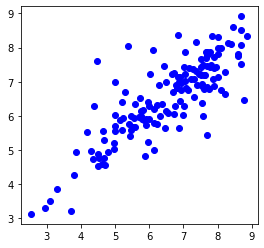

In [38]:
y_pred=sklearn_gpr.predict(test_dataset.X)

y_meas_test = transformers[0].untransform(test_dataset.y)
y_pred_test=transformers[0].untransform(y_pred)

plt.axes().set_aspect('equal')
plt.scatter(y_meas_test,y_pred_test,c='blue')

他のschikit-learnのモデルではどんな結果になるでしょうか？
https://sites.google.com/g.chuo-u.ac.jp/spec-group/ml-challenges　
などを参考に試してみましょう。

他に有名なデータセットとしては溶解度についてのDelaneyデータセットやZINCデータセットなどがあります。どんな問題やモデル構築が考えられるでしょうか。